## Universidad del Valle de Guatemala
##### Integrantes
* Juan Manuel Marroquin Alfaro 19845
* Carlos Alberto Raxtúm Ramos 19721
* Jose Abraham Gutierrez Corado 19111
* Walter Danilo Saldaña Salguero 19897
* Javier Alejandro Cotto Argueta 19324

## Investigación de PLN y Sistemas de Recomendación

Primeramente, la base de datos que escogimos esta basada en grabaciones de partidos de futbol de la liga alemana. Donde estos videos estan transcribidos
de forma que cada evento que ocurra en el partido se almacena, junto a su tiempo del evento(en segundo) y con su tipo de evento(pase, perdida/ganancia de posesión,
inicio y fin de la jugada, tiro libre, entre otras más). En base a esto, podemos detectar y reconocer cada tipo de evento que ocurra en un partido, en este caso
detectaremos lo que son los pases.

### Como parte de las tecnicas usadas para el Procesamiento de Lenguaje Natural, existen varias:

- Tokenizar
Esta tecnica consiste en separar cada palabra del texto  en entidades llamadas "tokens", de esta forma tendremos un mejor orden al trabajar con estas. Ademas de ello
a la hora de utilizar esta tecnica, se requiere identificar que utilizaremos como token y que no, por ejemplo contar las mayusculas y minusculas como un token o dos, 
los signos de puntuación seran tokens o no, y asi sucesivamente con cualquier letra o simbolo dentro de nuestras palabras.

- Tagging Part of Speech(PoS)
Esta tecnica se le conoce asi porque practicamente es trabajar las palabras como lo hacemos en la "vida real". Esto se debe a que clasificamos y reconocemos oraciones
mediante separarlas en articulo, verbo, sustantivo, adjetivo, entre otras más.

- Shallow parsing
Esta tecnica combina las dos anteriores, esto se debe a que con cada token obtenido y con cada clasificación hecha mediante PoS, se realiza un arbol que permite a la
computadora, navegar y moverse por el facilitando asi el entendimieno del lenguaje común para formar oraciones y con ellas parrafos.

- Pragmatic Analysis
Esta tecnica es más complicada para implemenetar, pues ademas de las anteriores, se incluye una clasificación de el como se mencionan o dicen las cosas. Esto quiere decir
que la tecnica se basa en interpretar el modo de las palabras, tales como sarcasmo, ironía, etc.

- Bag of Words
Esta tecnica combina el Tokenizar con el uso de matrices. Prácticamente llevara un conteo de las palabras que aparezcan en cierto parrafo mediante los tokens antes recabados.

- word2vec
Esta tecnica creemos que es una de las más eficientes, ya que recaba y memoriza cientos y cientos de palabras utilizadas en diferentes contextos. En base a estas, realiza
matrices de 300 dimensiones, las cuales guardan cada palabra cerca de otras palabras similares y de esta forma crear vocabularios que pueden ser utilizados por la 
computadora para interpretar cualquier parrafo.


# Problema planteado y datos

El problema es que hoy en día, la información y estadísticas de los partidos de fútbol son generados de forma manual por operadores humanos en tiempo real. Por la naturaleza de estos datos, son exclusivos para el uso de los profesionales que generan y por ende son dueños de los mismos datos o para competencias profesionales. Sin embargo, esta data sería muy valiosa para otras aplicaciones como por ejemplo para el fichaje y descrubrimiento de talento jóven, que quizá aún no tengan mucha visibilidad para las grandes organizaciones y por lo tanto no generen sufiecientes datos estadísticos para tener visibilidad y que no pasen por alto.

Para esto se nos pide poder detectar en videos de forma automática los pases en un partido inlcuyendose saques de banda y centros; y enfrentamientos entre jugadores de equipos contrarios en sus diferentes categorías (falta, robo de balón, entre otros), pasa así poder analizar competiciones inexploradas, como ligas juveniles o semiprofesionales o incluso sesiones de entrenamiento para así poder identificar talento oculto.

Los datos obtenidos de los clips de video nos serán de ayuda para entrenar un modelo que logre clasificar los eventos del partido en las categorías indicadas en función del tiempo del partido para así poder identificar los eventos de interes a los solicitados por los fichadores.

### Importar Librearías

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import norm
import scipy.stats as stats
import seaborn as sns
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video
from pandas_profiling import ProfileReport
%matplotlib inline

### Analisis Exploratorio

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
train = pd.read_csv('./videos/train.csv',low_memory=False)
# convert Nan to empty list
train[['event_attributes']] = train[['event_attributes']].fillna('')

In [4]:
train.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,
3,1606b0e6_0,210.124111,start,
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


Datos estadisticos

In [5]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,11218.0,1787.796418,860.84597,175.025822,1050.63525,1769.089449,2527.93275,3575.000727


In [6]:
train.describe(include=['O']).transpose()

,count,unique,top,freq
video_id,11218,12,1606b0e6_1,1249
event,11218,5,play,3586
event_attributes,11218,15,,6836


####  Cantidad de existencia de cada evento

<AxesSubplot:xlabel='count', ylabel='event'>

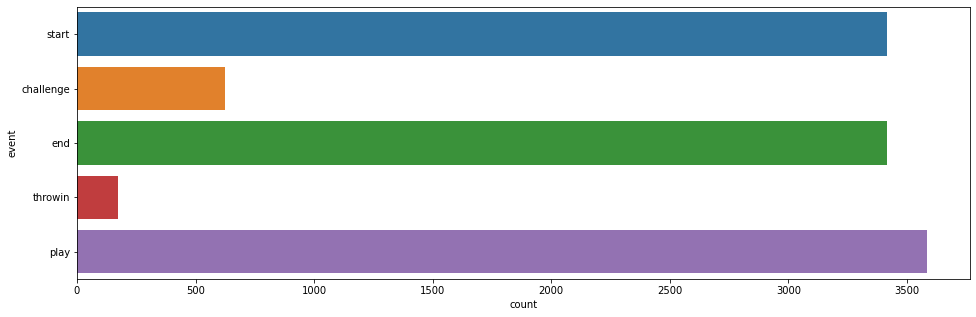

In [9]:
plt.figure(figsize=(16, 5))
sns.countplot(data=train, y="event")

#### Muestreo de los eventos en cierto video

<AxesSubplot:xlabel='count', ylabel='video_id'>

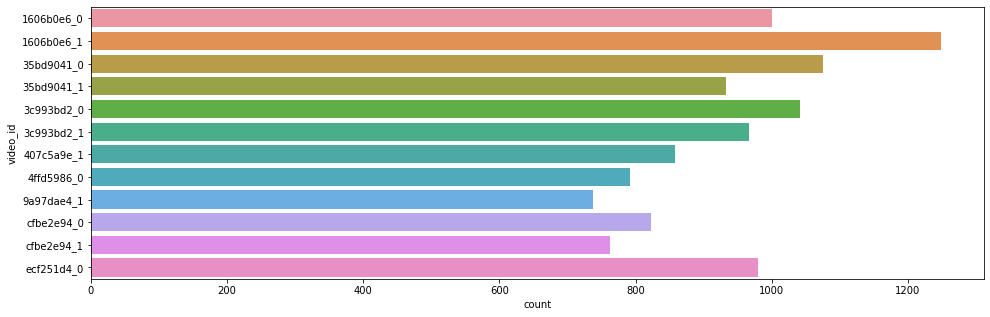

In [11]:
plt.figure(figsize=(16, 5))
sns.countplot(data=train, y="video_id")

#### Duración de eventos

<AxesSubplot:xlabel='count', ylabel='video_id'>

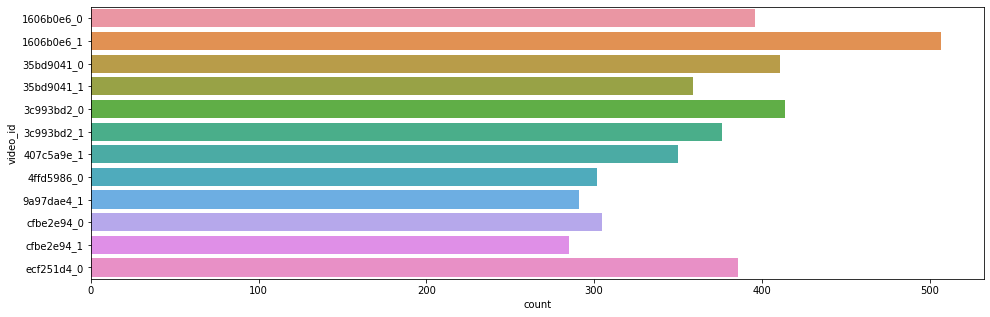

In [12]:
plt.figure(figsize=(16, 5))
sns.countplot(data=train[(train["event"] != "start") & (train["event"] != "end")], y="video_id")

## Eventos existentes en el dataset

### Visualizador de eventos

In [26]:
def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"test_{row['index']}.mp4"
    ffmpeg_extract_subclip(
        f"../detection_passes_football/videos/{row['video_id']}.mp4", 
        int(row['time']) - before, 
        int(row['time']) + after, 
        targetname=filename,
    )
    
    return Video(filename, width=800)

### Throwing

Un saque de banda se refiere a una situación en la que el juego se reinicia después de que el balón salió de juego por la línea de banda tras el toque del equipo contrario. El balón debe lanzarse con las manos, por detrás y por encima de la cabeza del jugador ejecutor.

In [23]:
df_throwin = train[train["event"] == "throwin"].reset_index()

Visualización de los eventos que perteneces a Throwing

<AxesSubplot:xlabel='count', ylabel='event_attributes'>

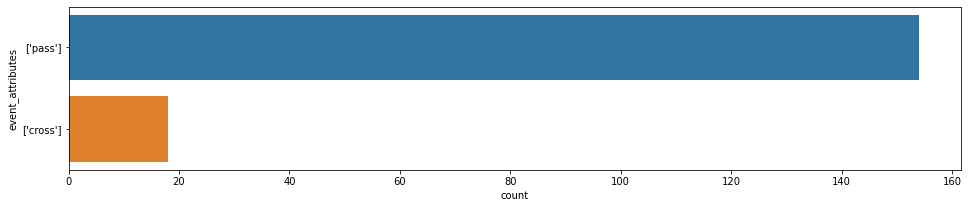

In [14]:
plt.figure(figsize=(16, 3))
sns.countplot(data=df_throwin, y="event_attributes")

Visualización de los eventos que perteneces a Throwing según el ID del video

<AxesSubplot:xlabel='video_id', ylabel='count'>

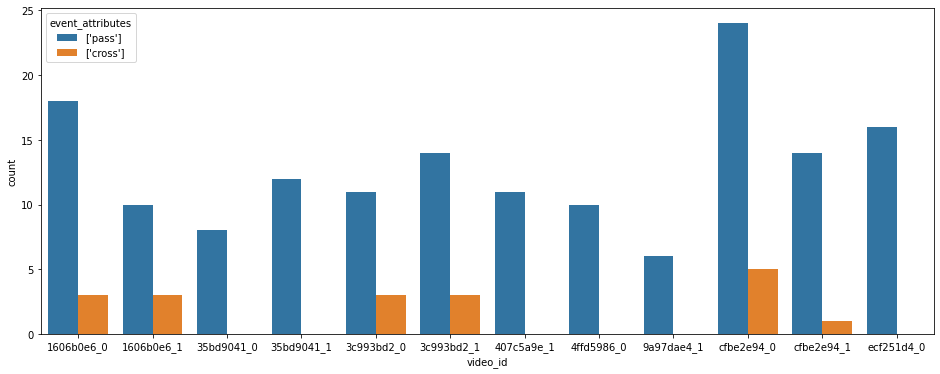

In [15]:
plt.figure(figsize=(16, 6))
sns.countplot(data=df_throwin, x="video_id", hue="event_attributes")

#### Pase

Definido como cualquier intento de cambiar el control del balón a otro miembro del equipo que no satisface la definición cruzada.

In [27]:
vis_event(df_throwin.iloc[0])

['pass']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command returned an error


OSError: ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9.2.1 (GCC) 20200122
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
../videos/train.csv/1606b0e6_0.mp4: No such file or directory


In [35]:
print(os.listdir("../detection_passes_football/videos/"))

['train.csv']
